# Data Understanding and Exploration

## Import necessary modules

In [357]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("../") 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Data processing modules
import numpy as np
import category_encoders as ce
from sklearn.feature_extraction.text import TfidfVectorizer

# Model development modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import tensorflow as tf
from tensorflow import keras
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import xgboost as xgb

# Import custom modules
from src.data.data_ingestion import ingest_raw_data
from src.utils.visualization import plot_feature_distribution, plot_feature_binned_distribution, plot_non_missing_story_points_distribution, plot_boxplot, plot_actual_vs_predicted, plot_residual, plot_neural_network_training_history
from src.data.data_processing import missing_value_statistics, log_transform_outliers, remove_duplicates, identify_outliers, assess_unique_values
from src.utils.fgra import grey_relational_analysis
from src.models.train import train_model, train_ann_model
from src.models.evaluate import evaluate_model
from src.utils.model_persistence import save_model

## Data Loading

### Ingest raw data from MySql database

In [358]:
raw_data = ingest_raw_data()

[2023-08-24 07:00:51,568] 56 src.utils.logger - INFO - Started data ingestion process...
[2023-08-24 07:00:51,569] 59 src.utils.logger - INFO - Data already ingested to CSV: /home/umar/Workspace/personal/msc-dissertation/src/data/../../data/raw/raw.csv


### Load raw data into a data frame

In [359]:
# Load the dataset
# data = pd.read_csv(raw_data)
data = pd.read_csv('../data/raw/raw_data_full_.csv')

# Display the first few rows to inspect the structure
data.head()

,Issue_Key,Jira_ID,Title,Description,Type,Priority,Status,Resolution,Story_Point,Story_Point_Changed_After_Estimation,...,In_Progress_Minutes,Total_Effort_Minutes,Title_Changed_After_Estimation,Description_Changed_After_Estimation,Project_ID,Sprint_ID,Creation_Date,Estimation_Date,Resolution_Date,Last_Updated
0,XD-3768,77638,"""How do I make a job restartable in spring xd""","""The jobs that appear under Executions section...",Bug,Major,To Do,NaN,1.0,0,...,0.0,0.0,0,0,1,NaN,2017-07-10 13:41:25,2017-07-10 12:41:25,NaN,2017-07-10 13:41:25
1,XD-3767,77511,"""admin config timezone command does not work""","""Working with Spring-XD version 1.3.2.RELEASE ...",Bug,Trivial,To Do,NaN,1.0,0,...,0.0,0.0,0,0,1,NaN,2017-06-26 16:26:27,2017-06-26 15:26:27,NaN,2017-06-26 16:26:27
2,XD-3766,77130,"""Module Upload command not pushing jar to all ...","""My project 7 node cluster and in that 2 node ...",Bug,Major,To Do,NaN,10.0,0,...,0.0,0.0,0,0,1,NaN,2017-05-19 22:28:43,2017-05-19 21:28:43,NaN,2017-05-19 22:28:43
3,XD-3765,71950,"""Fix stream failover ""","""See https://github.com/spring-projects/spring...",Story,Minor,Done,Complete,8.0,0,...,0.0,0.0,1,0,1,NaN,2017-03-21 16:54:44,2017-03-21 16:54:44,2017-03-21 16:55:23,2017-03-22 18:27:01
4,XD-3764,71805,"""SpringXD Job is still executing even after fo...","""I'm trying to run a Job on SpringXD and the j...",Bug,Major,To Do,NaN,5.0,0,...,0.0,0.0,0,0,1,NaN,2017-03-06 20:01:41,2017-03-06 20:01:41,NaN,2017-03-06 20:01:41


## Understanding the dataset

In [360]:
# Describe the dataset attributes
data.describe(include='all')

,Issue_Key,Jira_ID,Title,Description,Type,Priority,Status,Resolution,Story_Point,Story_Point_Changed_After_Estimation,...,In_Progress_Minutes,Total_Effort_Minutes,Title_Changed_After_Estimation,Description_Changed_After_Estimation,Project_ID,Sprint_ID,Creation_Date,Estimation_Date,Resolution_Date,Last_Updated
count,458232,4.582320e+05,458232,429104,458232,331573,458232,380734,6.542700e+04,458232.000000,...,4.582320e+05,4.582320e+05,458232.000000,458232.0,458232.000000,43475.000000,458232,65427,352632,458232
unique,458232,NaN,412868,421333,24,16,76,54,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,424980,64462,304906,251195
top,XD-3768,NaN,"""Failed: on Ubuntu 16.04 [Evergreen Self-Test...",""" h2. [ failed on Ubuntu 16.04|https://evergre...",Bug,Low,Closed,Fixed,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018-08-03 16:47:02,2017-06-16 15:06:07,2006-08-24 10:33:26,2019-09-19 06:50:48
freq,1,NaN,485,485,215570,65819,334368,160857,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,17,7,31,83
mean,NaN,6.842263e+05,NaN,NaN,NaN,NaN,NaN,NaN,4.135718e+02,0.020068,...,5.238023e+03,2.343935e+04,0.141330,0.0,24.998507,2711.075791,NaN,NaN,NaN,NaN
std,NaN,2.121512e+06,NaN,NaN,NaN,NaN,NaN,NaN,1.044232e+05,0.140235,...,5.792574e+04,1.286546e+05,0.348362,0.0,10.805999,1512.380726,NaN,NaN,NaN,NaN
min,NaN,1.000000e+04,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.0,1.000000,1.000000,NaN,NaN,NaN,NaN
25%,NaN,5.834075e+04,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.0,18.000000,1395.500000,NaN,NaN,NaN,NaN
50%,NaN,1.471675e+05,NaN,NaN,NaN,NaN,NaN,NaN,3.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.0,23.000000,2941.000000,NaN,NaN,NaN,NaN
75%,NaN,6.167282e+05,NaN,NaN,NaN,NaN,NaN,NaN,5.000000e+00,0.000000,...,0.000000e+00,1.458000e+03,0.000000,0.0,34.000000,4053.000000,NaN,NaN,NaN,NaN


In [361]:
# Describe concise summary of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458232 entries, 0 to 458231
Data columns (total 22 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Issue_Key                             458232 non-null  object 
 1   Jira_ID                               458232 non-null  int64  
 2   Title                                 458232 non-null  object 
 3   Description                           429104 non-null  object 
 4   Type                                  458232 non-null  object 
 5   Priority                              331573 non-null  object 
 6   Status                                458232 non-null  object 
 7   Resolution                            380734 non-null  object 
 8   Story_Point                           65427 non-null   float64
 9   Story_Point_Changed_After_Estimation  458232 non-null  int64  
 10  Timespent                             10243 non-null   float64
 11  

In [362]:
# Describe the shape of the dataset
data.shape

(458232, 22)

In [363]:
# Describe the data type of each column in the dataset
data.dtypes

Issue_Key                                object
Jira_ID                                   int64
Title                                    object
Description                              object
Type                                     object
Priority                                 object
Status                                   object
Resolution                               object
Story_Point                             float64
Story_Point_Changed_After_Estimation      int64
Timespent                               float64
Resolution_Time_Minutes                 float64
In_Progress_Minutes                     float64
Total_Effort_Minutes                    float64
Title_Changed_After_Estimation            int64
Description_Changed_After_Estimation      int64
Project_ID                                int64
Sprint_ID                               float64
Creation_Date                            object
Estimation_Date                          object
Resolution_Date                         

## Exploratory Data Analysis (EDA)

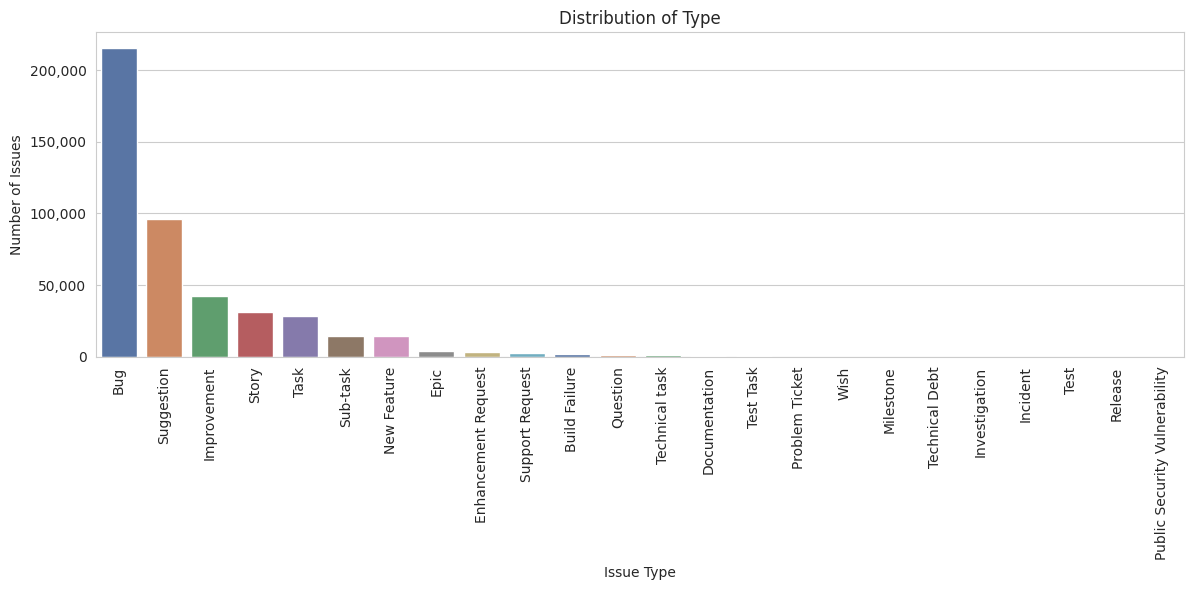

In [364]:
# Plot distribution of issue types
plot_feature_distribution(data=data, feature={'name': 'Type', 'label': 'Issue Type'})

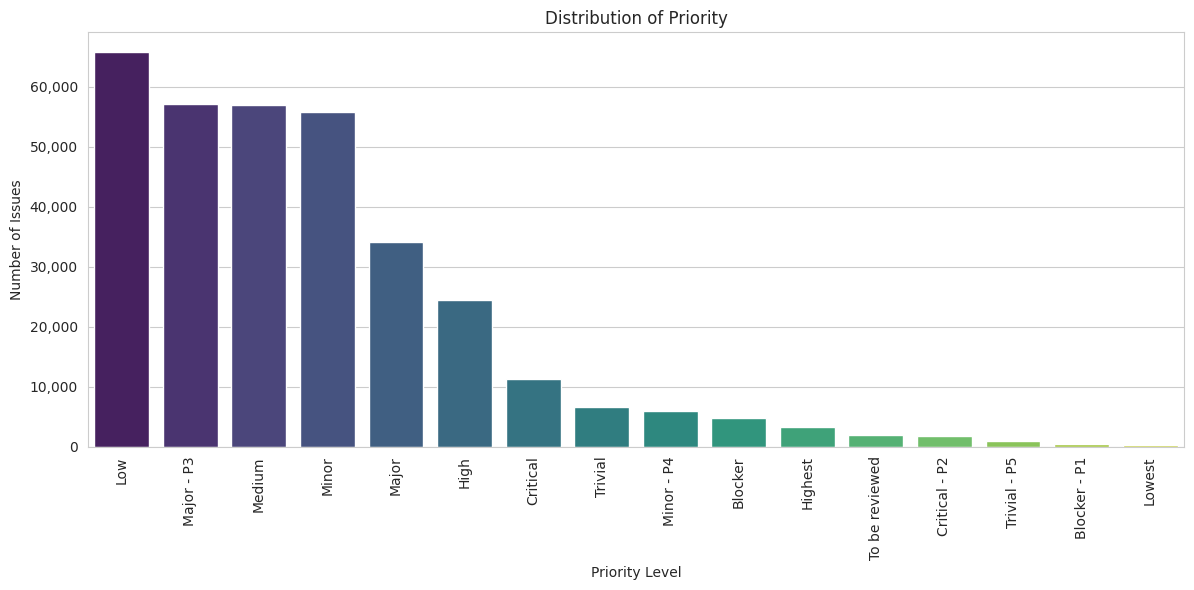

In [365]:
# Plot distribution of priorities
plot_feature_distribution(data=data, feature={'name': 'Priority', 'label': 'Priority Level'}, palette='viridis')

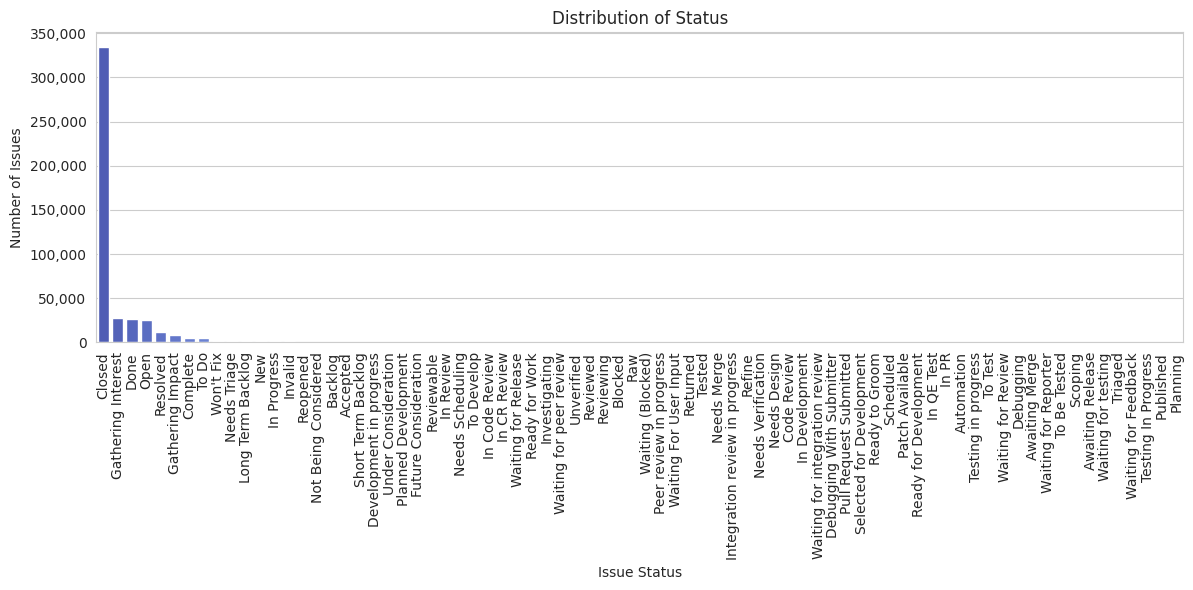

In [366]:
# Plot distribution of issue statuses
plot_feature_distribution(data=data, feature={'name': 'Status', 'label': 'Issue Status'}, palette='coolwarm')

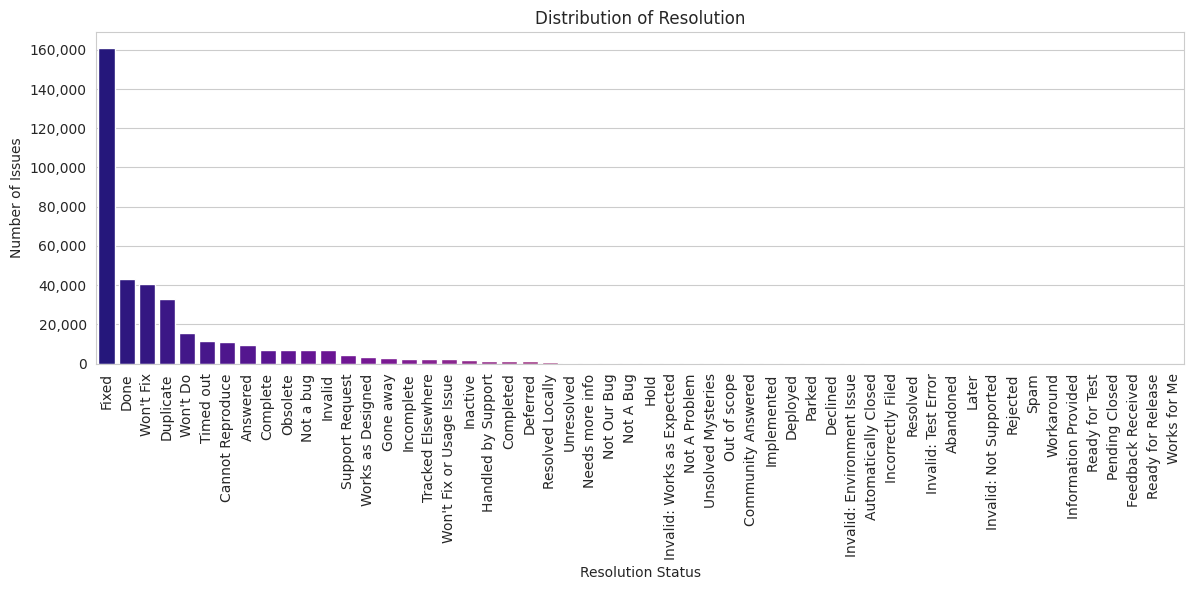

In [367]:
# Plot distribution of resolution statuses
plot_feature_distribution(data=data, feature={'name': 'Resolution', 'label': 'Resolution Status'}, palette='plasma')

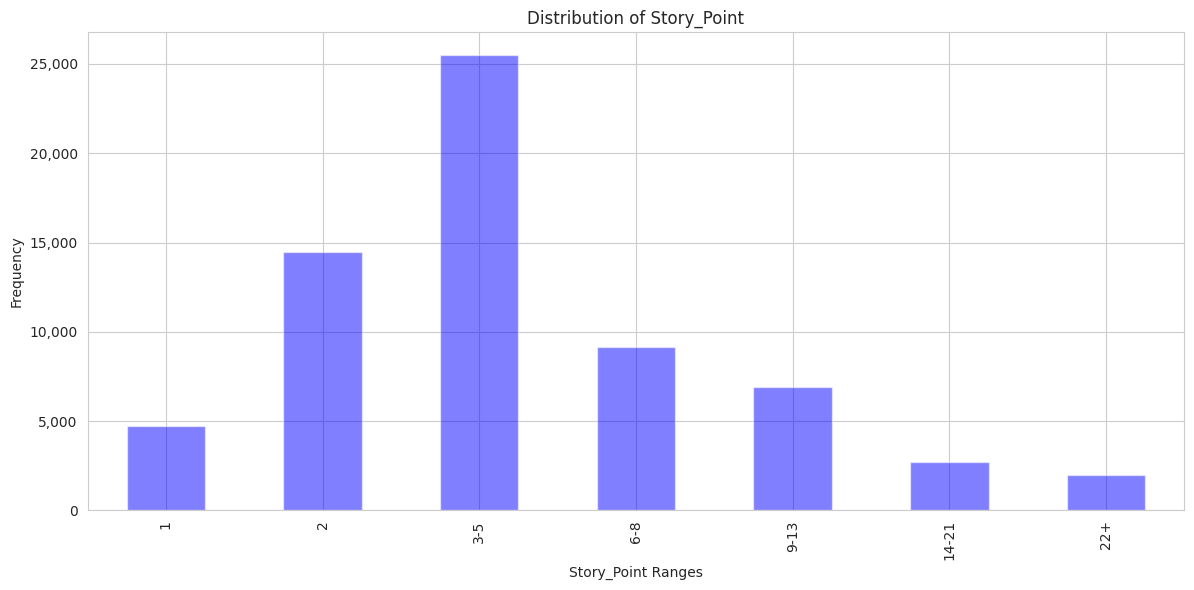

In [368]:
# Plot distribution of story points
plot_feature_binned_distribution(data=data, feature={'name': 'Story_Point', 'label': 'Story Point Value Ranges'}, palette='magma')

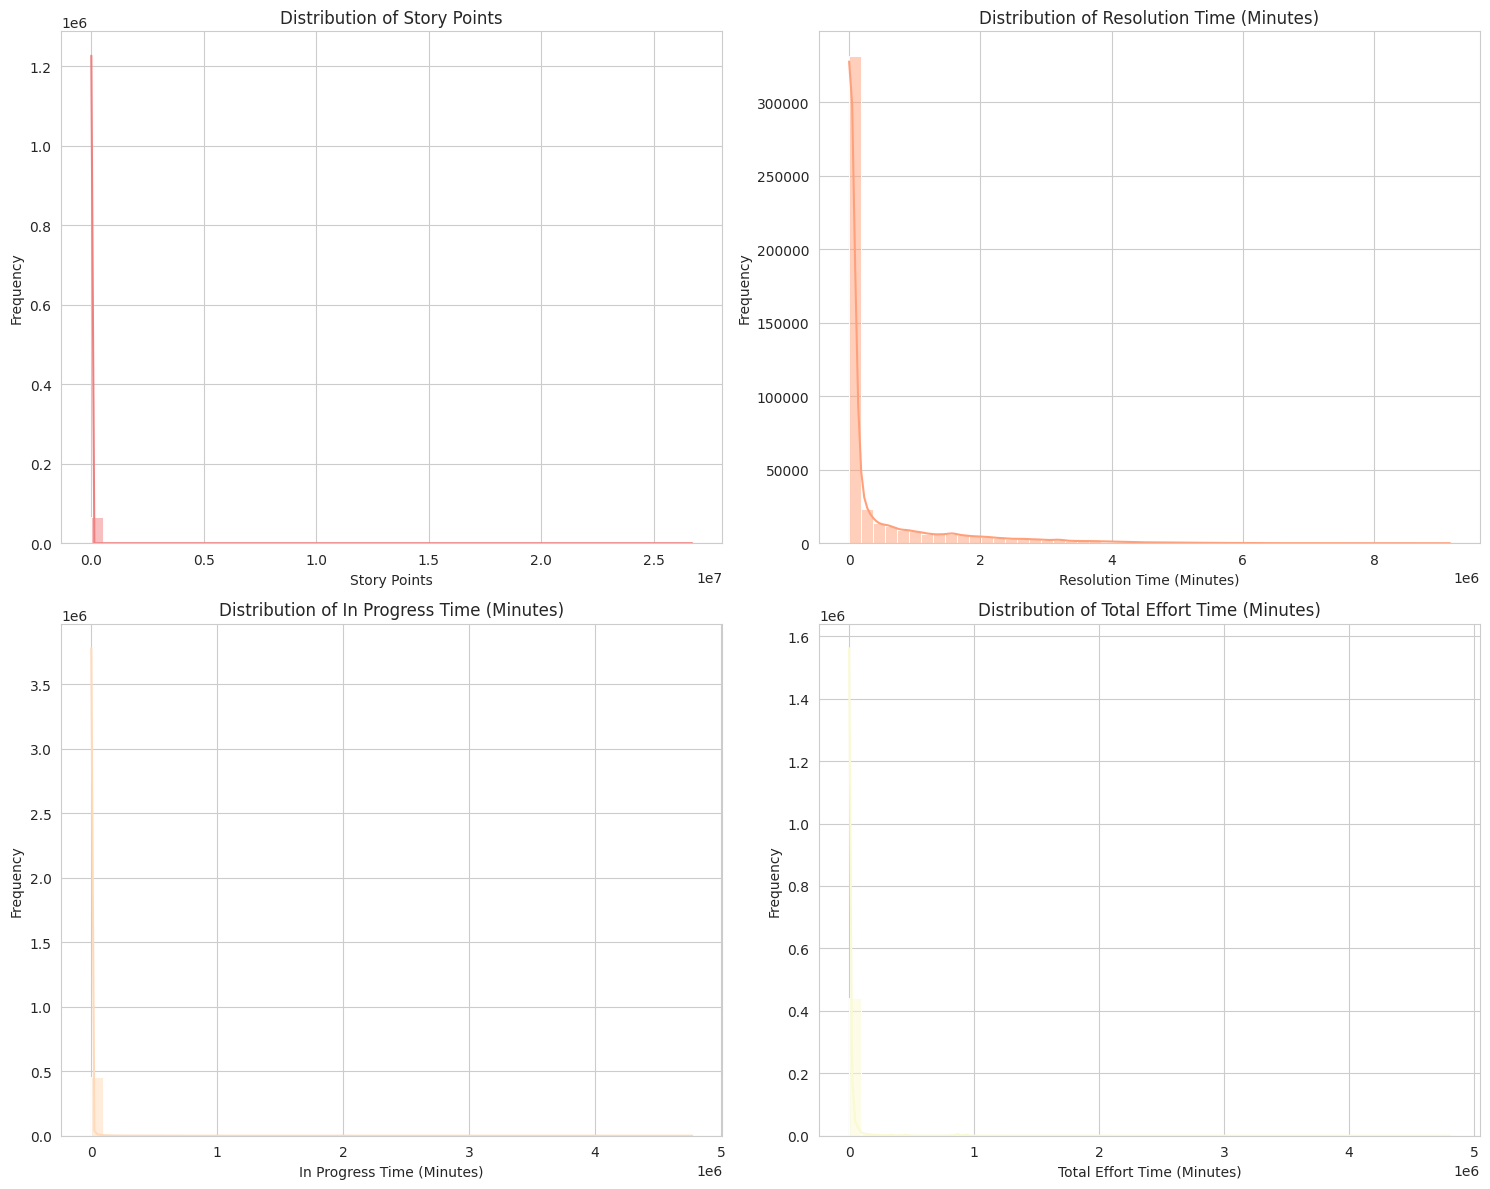

In [369]:
# Distribution Analysis of Key Columns
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Story_Point Distribution
sns.histplot(data['Story_Point'], bins=50, kde=True, ax=axes[0, 0], color='lightcoral')
axes[0, 0].set_title('Distribution of Story Points')
axes[0, 0].set_xlabel('Story Points')
axes[0, 0].set_ylabel('Frequency')

# Resolution_Time_Minutes Distribution
sns.histplot(data['Resolution_Time_Minutes'], bins=50, kde=True, ax=axes[0, 1], color='lightsalmon')
axes[0, 1].set_title('Distribution of Resolution Time (Minutes)')
axes[0, 1].set_xlabel('Resolution Time (Minutes)')
axes[0, 1].set_ylabel('Frequency')

# In_Progress_Minutes Distribution
sns.histplot(data['In_Progress_Minutes'], bins=50, kde=True, ax=axes[1, 0], color='peachpuff')
axes[1, 0].set_title('Distribution of In Progress Time (Minutes)')
axes[1, 0].set_xlabel('In Progress Time (Minutes)')
axes[1, 0].set_ylabel('Frequency')

# Total_Effort_Minutes Distribution
sns.histplot(data['Total_Effort_Minutes'], bins=50, kde=True, ax=axes[1, 1], color='lightgoldenrodyellow')
axes[1, 1].set_title('Distribution of Total Effort Time (Minutes)')
axes[1, 1].set_xlabel('Total Effort Time (Minutes)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


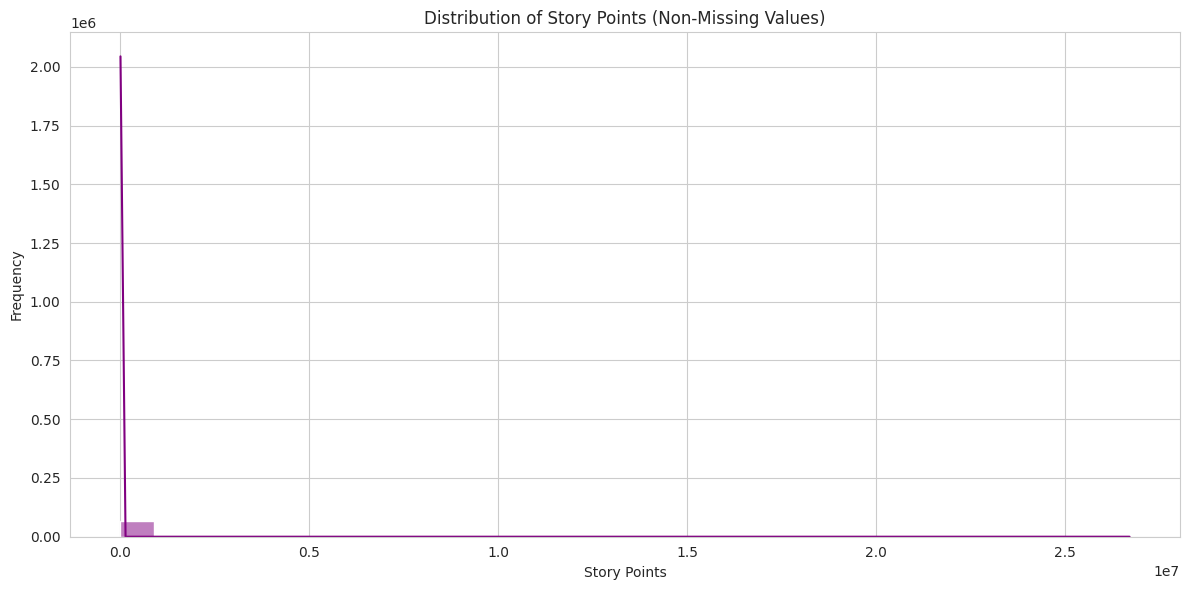

In [370]:
# Plot distribution of story points for non-missing values
plot_non_missing_story_points_distribution(data)

# Data Preprocessing

## Data cleaning

In [371]:
# Check missing values
missing_value_statistics(data)

,Missing Values,Percentage
Timespent,447989,97.764669
Sprint_ID,414757,90.512448
Story_Point,392805,85.721861
Estimation_Date,392805,85.721861
Priority,126659,27.640802
Resolution_Date,105600,23.045095
Resolution,77498,16.912394
Description,29128,6.356605


In [372]:
# Drop the top two columns with the highest missing values
data.drop('Timespent', axis=1, inplace=True)
# data.drop('Sprint_ID', axis=1, inplace=True)

In [373]:
# Convert date columns to datetime format
date_columns = ['Creation_Date', 'Estimation_Date', 'Resolution_Date', 'Last_Updated']
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Check the data types again to confirm conversion
data[date_columns].dtypes

Creation_Date      datetime64[ns]
Estimation_Date    datetime64[ns]
Resolution_Date    datetime64[ns]
Last_Updated       datetime64[ns]
dtype: object

In [374]:
# Impute missing values for 'Sprint_ID' with -1
data['Sprint_ID'].fillna(-1, inplace=True)

# Drop irrelevant columns
data.drop('Jira_ID', axis=1, inplace=True)

# Impute missing values for 'Priority' with its mode
data['Priority'].fillna(data['Priority'].mode()[0], inplace=True)

# Impute missing values for 'Resolution'
data['Resolution'].fillna('Unknown', inplace=True)

# Impute missing values for 'Estimation_Date' with 'Creation_Date'
data['Estimation_Date'] = data['Estimation_Date'].fillna(data['Creation_Date'])

# Impute missing values for 'Description' with 'No description'
data['Description'].fillna('No description', inplace=True)

In [375]:
# Check remaining missing values
missing_value_statistics(data)

,Missing Values,Percentage
Story_Point,392805,85.721861
Resolution_Date,105600,23.045095


In [376]:
# Impute missing values for 'Story_Point' with its median
# data['Story_Point'].fillna(data['Story_Point'].median(), inplace=True)
data.dropna(subset=['Story_Point'], inplace=True)

In [377]:
# Create a binary column 'Has_Resolution_Date' and drop the original 'Resolution_Date'
data['Has_Resolution_Date'] = data['Resolution_Date'].notna().astype(int)
data.drop(columns='Resolution_Date', inplace=True)

In [378]:
# Check if there are any remaining missing values
missing_value_statistics(data)

,Missing Values,Percentage


In [379]:
remove_duplicates(data)

Duplicate rows removed: 0


In [380]:
# List of numerical columns to check for outliers
columns_to_check = ['Story_Point']
# columns_to_check = ['Story_Point', 'In_Progress_Minutes', 'Total_Effort_Minutes']

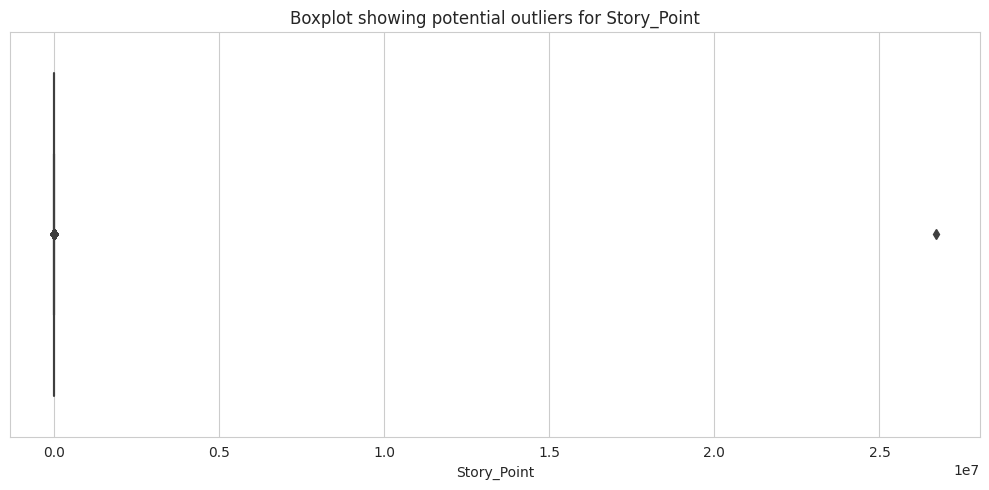

In [381]:
# Plot boxplots Story_Point
plot_boxplot(data=data, feature='Story_Point', title='Boxplot showing potential outliers for Story_Point')

In [382]:
outliers_stats = identify_outliers(data, columns_to_check)

Story_Point: 7.677258624115427


In [383]:
# Apply logarithmic transformation to the columns
data = log_transform_outliers(data, columns_to_check)

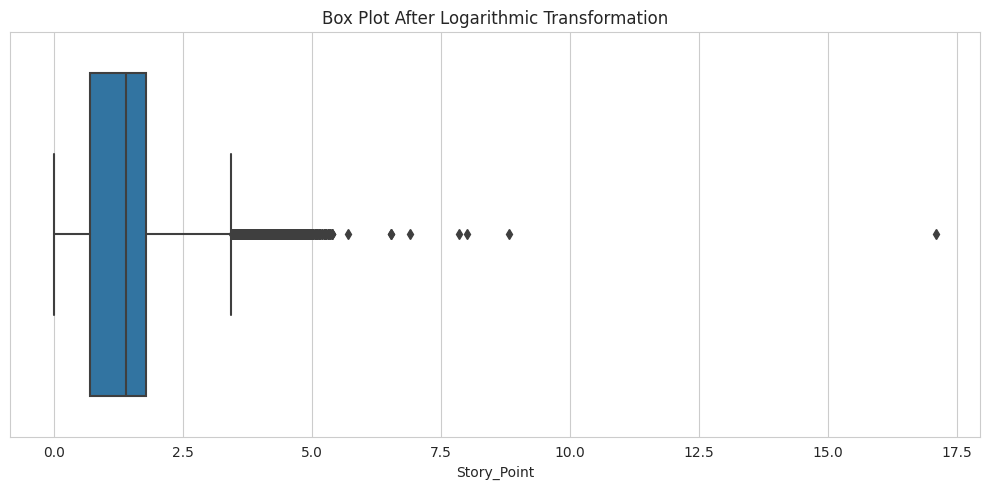

In [384]:
# Visualize the transformed distributions
plot_boxplot(data=data, feature='Story_Point', title='Box Plot After Logarithmic Transformation')

In [385]:
outliers_stats_after_log_transformation = identify_outliers(data, columns_to_check)

Story_Point: 2.077124123068458


## Feature Engineering

### Create new features

In [386]:
# Extract the time difference between Creation_Date and Estimation_Date
data['Time_To_Estimate_Minutes'] = (data['Estimation_Date'] - data['Creation_Date']).dt.days

In [387]:
# Extract text-based features for 'Title' and 'Description' columns
issue_text_columns = ['Title', 'Description']

for column in issue_text_columns:
    # Length of the text
    data[f'{column}_Length'] = data[column].apply(len)
    # Number of unique words
    data[f'{column}_Unique_Words'] = data[column].apply(lambda x: len(set(x.split())))

# Check the first few rows to verify the new columns
data.head()

,Issue_Key,Title,Description,Type,Priority,Status,Resolution,Story_Point,Story_Point_Changed_After_Estimation,Resolution_Time_Minutes,...,Sprint_ID,Creation_Date,Estimation_Date,Last_Updated,Has_Resolution_Date,Time_To_Estimate_Minutes,Title_Length,Title_Unique_Words,Description_Length,Description_Unique_Words
0,XD-3768,"""How do I make a job restartable in spring xd""","""The jobs that appear under Executions section...",Bug,Major,To Do,Unknown,0.693147,0,0.0,...,-1.0,2017-07-10 13:41:25,2017-07-10 12:41:25,2017-07-10 13:41:25,0,-1,46,10,130,24
1,XD-3767,"""admin config timezone command does not work""","""Working with Spring-XD version 1.3.2.RELEASE ...",Bug,Trivial,To Do,Unknown,0.693147,0,0.0,...,-1.0,2017-06-26 16:26:27,2017-06-26 15:26:27,2017-06-26 16:26:27,0,-1,45,7,1027,68
2,XD-3766,"""Module Upload command not pushing jar to all ...","""My project 7 node cluster and in that 2 node ...",Bug,Major,To Do,Unknown,2.397895,0,0.0,...,-1.0,2017-05-19 22:28:43,2017-05-19 21:28:43,2017-05-19 22:28:43,0,-1,57,9,549,66
3,XD-3765,"""Fix stream failover ""","""See https://github.com/spring-projects/spring...",Story,Minor,Done,Complete,2.197225,0,0.0,...,-1.0,2017-03-21 16:54:44,2017-03-21 16:54:44,2017-03-22 18:27:01,1,0,22,4,62,2
4,XD-3764,"""SpringXD Job is still executing even after fo...","""I'm trying to run a Job on SpringXD and the j...",Bug,Major,To Do,Unknown,1.791759,0,0.0,...,-1.0,2017-03-06 20:01:41,2017-03-06 20:01:41,2017-03-06 20:01:41,0,0,69,10,1161,114


### Categorical Encoding

In [388]:
categorical_columns = ['Type', 'Priority', 'Status', 'Resolution']
unique_values_statistics = assess_unique_values(data, categorical_columns)
print(unique_values_statistics)

Type          19
Priority      16
Status        48
Resolution    45
dtype: int64


In [389]:
# Binary encoding for 'Status' and 'Resolution'
binary_encoder = ce.BinaryEncoder(cols=['Status', 'Resolution'])
data = binary_encoder.fit_transform(data)

# One-Hot encoding for 'Type' and 'Priority'
data = pd.get_dummies(data, columns=['Type', 'Priority'], drop_first=True)

In [390]:
# from sklearn.preprocessing import LabelEncoder
# 
# # Columns to be label encoded
# columns_to_encode = ["Type", "Priority", "Status", "Resolution"]
# 
# encoded_data = data.copy()
# 
# # Apply label encoding to the columns
# for col in columns_to_encode:
#     le = LabelEncoder()
#     encoded_data[col] = le.fit_transform(encoded_data[col])
#     label_encoders[col] = le  # store the encoder for potential use later
# 
# # Display the first few rows after label encoding
# encoded_data[columns_to_encode].head()

In [391]:
# columns_to_encode = ['Type', 'Priority', 'Status', 'Resolution']
# encoded_data = data.copy()
# encode_labels(encoded_data, columns_to_encode)
# 
# encoded_data[columns_to_encode].head()

### Feature Scaling

In [392]:
from sklearn.preprocessing import StandardScaler

# Identify the continuous columns (excluding the binary-encoded ones)
# features_to_scale = ['Story_Point', 'Resolution_Time_Minutes', 'In_Progress_Minutes', 'Total_Effort_Minutes', 'Time_To_Estimate_Minutes', 'Title_Length', 'Description_Length', 'Title_Unique_Words', 'Description_Unique_Words']
features_to_scale = ['Title_Length', 'Description_Length', 'Title_Unique_Words', 'Description_Unique_Words']

# Apply standardization
scaler = StandardScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

## Feature Selection with Fuzzy GRA

### Data Normalization

### Calculate Grey Relational Coefficient

### Compute Grey Relational Grade

### Feature Ranking

In [393]:
ranked_features = grey_relational_analysis(data, target_col='Story_Point')
print(ranked_features)

Description_Unique_Words                0.872979
Total_Effort_Minutes                    0.869746
In_Progress_Minutes                     0.867963
Description_Length                      0.865710
Resolution_Time_Minutes                 0.864578
Status_0                                0.860448
Resolution_1                            0.859939
Resolution_0                            0.851769
Resolution_3                            0.836063
Status_1                                0.832945
Status_2                                0.829995
Title_Unique_Words                      0.806344
Title_Length                            0.804813
Story_Point_Changed_After_Estimation    0.804781
Title_Changed_After_Estimation          0.771020
Sprint_ID                               0.726432
Status_4                                0.628386
Resolution_5                            0.606170
Project_ID                              0.581580
Status_3                                0.571567
Status_5            

### Visualise the feature importance

[2023-08-24 07:01:32,817] 876 matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f4d4a010550>


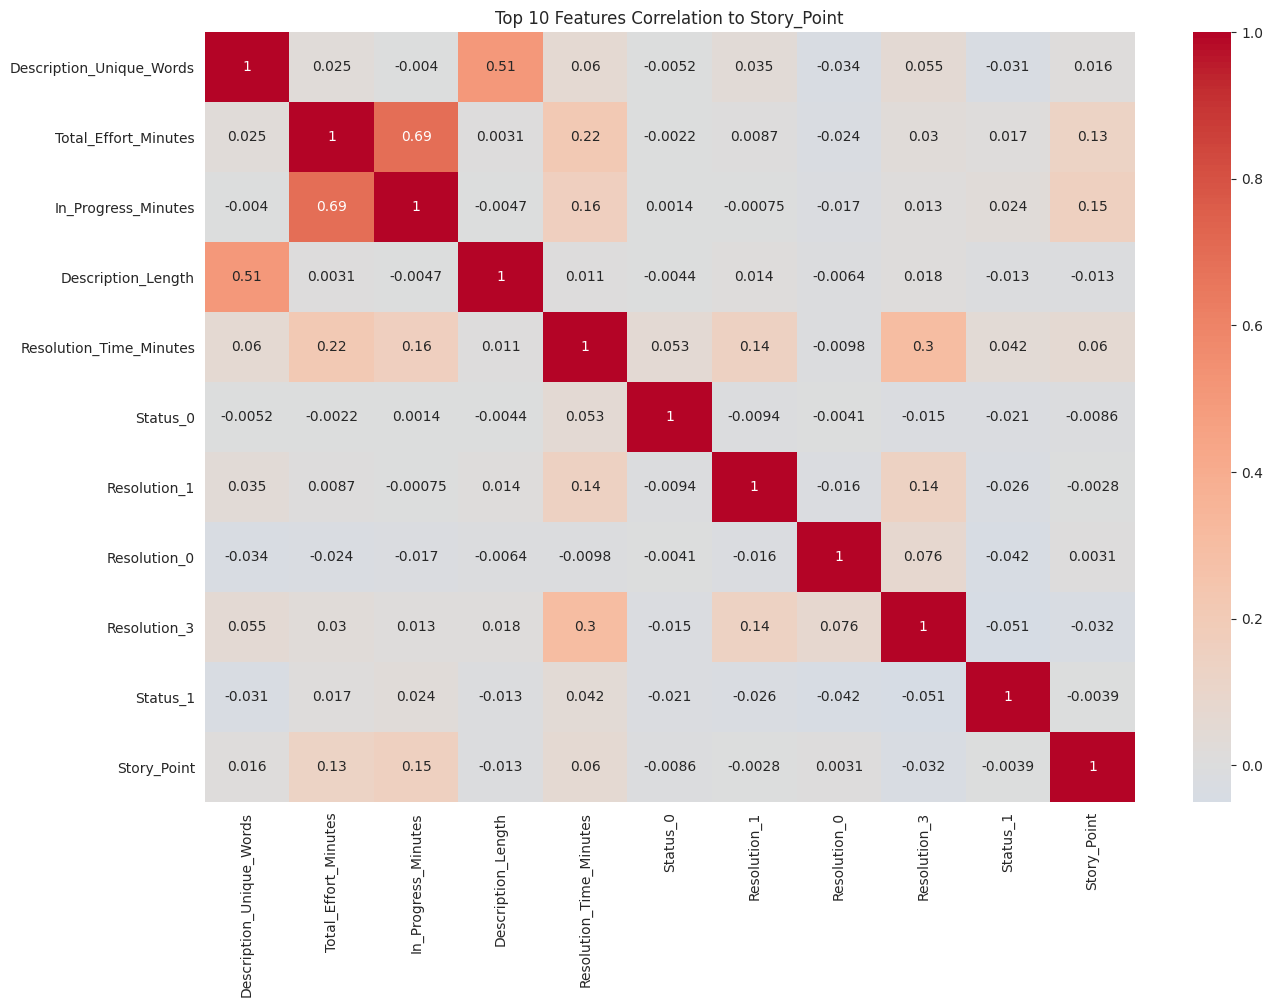

In [394]:
top_features_with_highest_ranking_with_sp = ranked_features.index[:10]

# Create a smaller correlation matrix with only the top features including 'Story_Point'
small_corr_matrix = data[top_features_with_highest_ranking_with_sp].join(data['Story_Point']).corr()

# Plotting the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(small_corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Top 10 Features Correlation to Story_Point')
plt.show()

# Model Development (Without the selected features)

## Data Splitting

In [395]:
# new_data = data.drop(columns=['Jira_ID', 'Title', 'Description', 'Issue_Key', 'Creation_Date', 'Estimation_Date', 'Resolution_Date', 'Last_Updated'], errors='ignore')

# Features and target variable
X = data.drop(columns=['Story_Point', 'Title', 'Description', 'Issue_Key', 'Creation_Date', 'Estimation_Date', 'Last_Updated'])
y = data['Story_Point']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regression (Baseline Model)

In [396]:
%%time
baseline_model_name = 'Linear Regression (Baseline Model)'
baseline_model = LinearRegression()
baseline_predictions = train_model(baseline_model, X_train, y_train, X_test)
print(f'{baseline_model_name} Metrics:')
baseline_model_metrics = evaluate_model(y_test, baseline_predictions)

Linear Regression (Baseline Model) Metrics:
MSE: 0.47791554999536706
RMSE: 0.6913143640887025
MAE: 0.5111835615008778
R2: 0.2621884676871915
CPU times: user 1.96 s, sys: 4.41 s, total: 6.37 s
Wall time: 622 ms


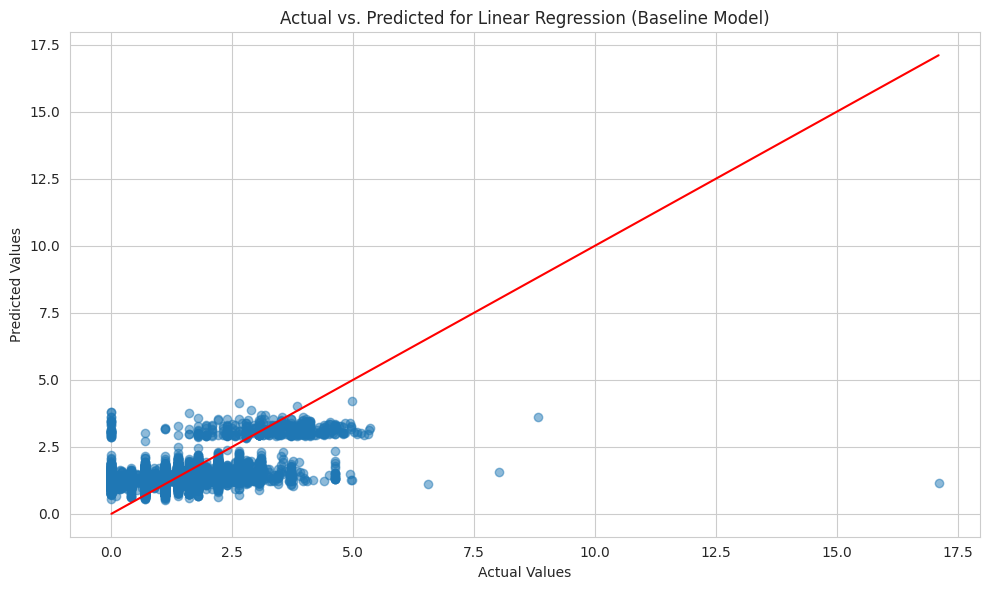

In [397]:
plot_actual_vs_predicted(y_test, baseline_predictions, baseline_model_name)

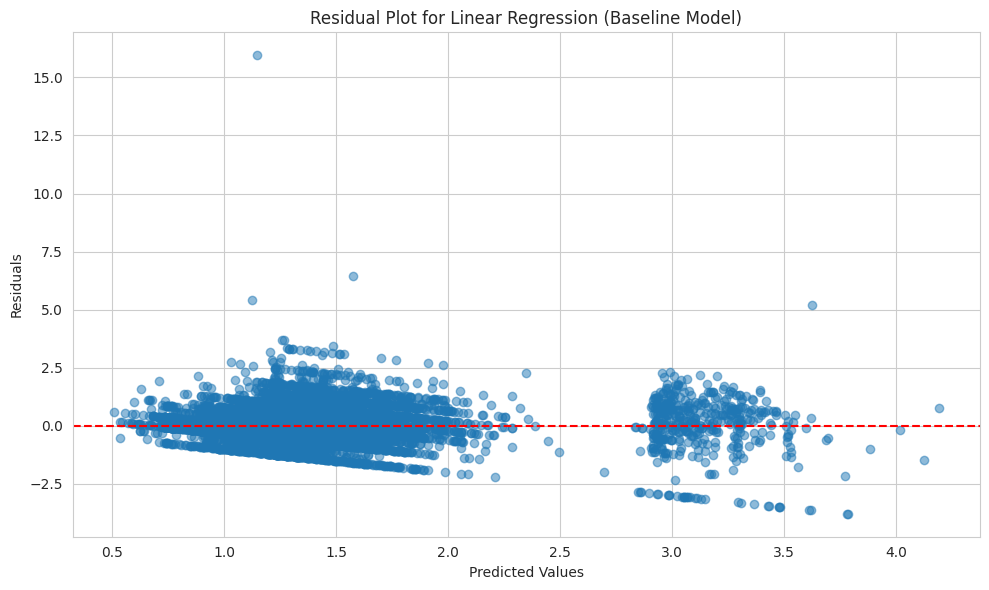

In [398]:
plot_residual(y_test, baseline_predictions, baseline_model_name)

## Random Forest model

In [399]:
%%time
rf_model_name = 'Random Forest Regression'
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_predictions = train_model(rf_model, X_train, y_train, X_test)
print(f'{rf_model_name} Metrics:')
rf_model_metrics = evaluate_model(y_test, rf_predictions)

Random Forest Regression Metrics:
MSE: 0.3552306454008884
RMSE: 0.596012286283503
MAE: 0.41937952761734437
R2: 0.45159083689526713
CPU times: user 46.4 s, sys: 0 ns, total: 46.4 s
Wall time: 46.4 s


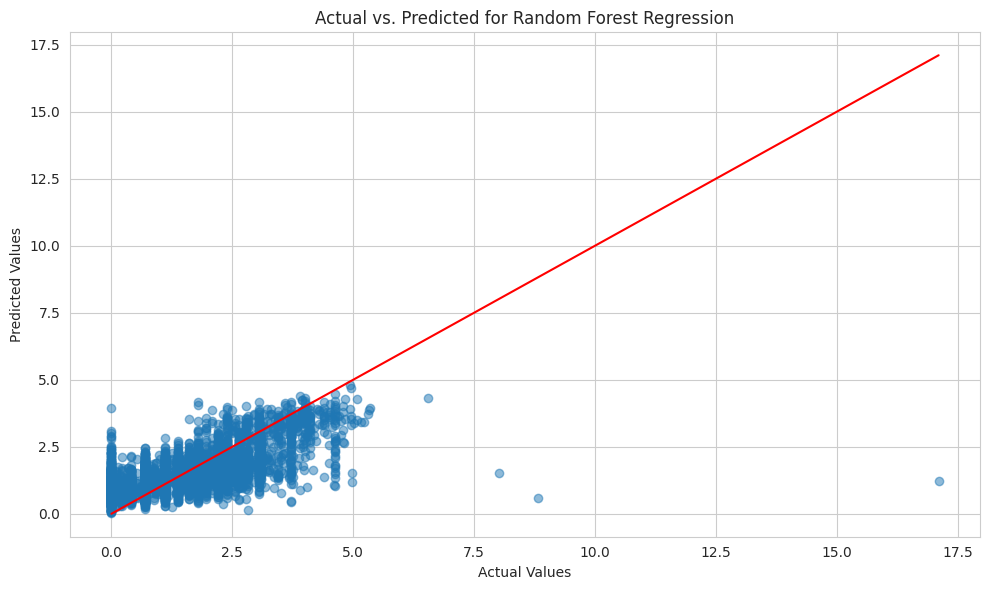

In [400]:
plot_actual_vs_predicted(y_test, rf_predictions, rf_model_name)

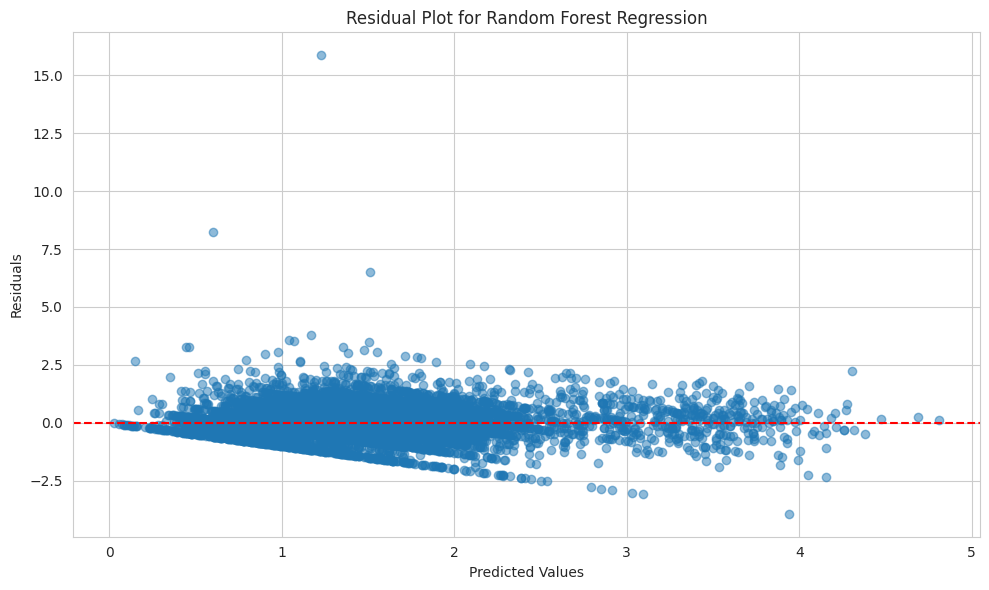

In [401]:
plot_residual(y_test, rf_predictions, rf_model_name)

## Gradient Boosting model

In [402]:
%%time
xgb_model_name = 'Gradient Boosting Regression'
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_predictions = train_model(xgb_model, X_train, y_train, X_test)
print(f'{xgb_model_name} Metrics:')
xgb_model_metrics = evaluate_model(y_test, xgb_predictions)

Gradient Boosting Regression Metrics:
MSE: 0.36320847955761526
RMSE: 0.6026678019917899
MAE: 0.43366275222514744
R2: 0.43927456460873204
CPU times: user 1min 11s, sys: 140 ms, total: 1min 11s
Wall time: 4.61 s


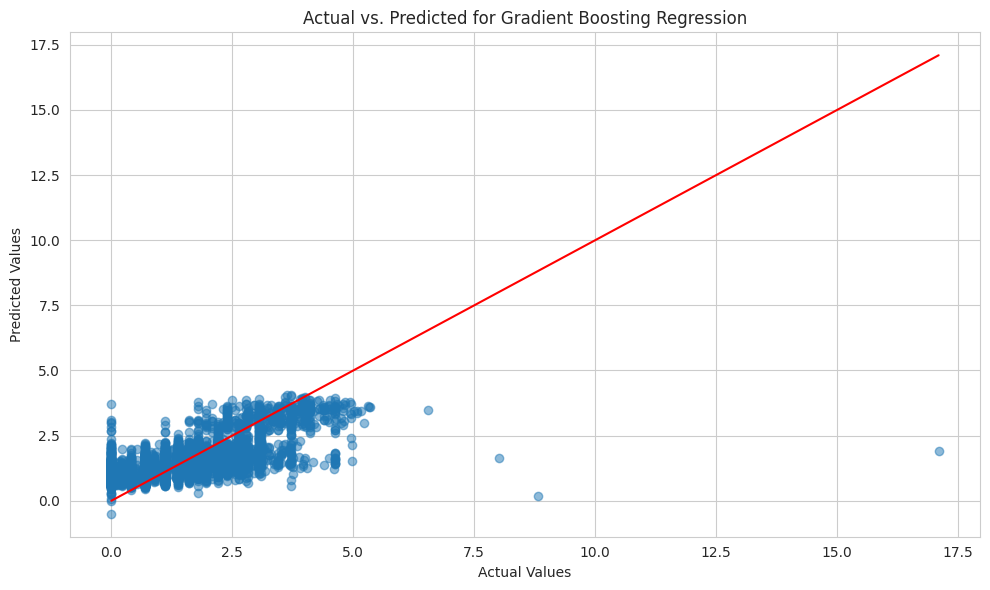

In [403]:
plot_actual_vs_predicted(y_test, xgb_predictions, xgb_model_name)

## Artificial Neural Networks (ANN)

In [404]:
%%time
ann_model_name = 'Artificial Neural Networks (ANN)'
ann_predictions, history = train_ann_model(X_train, y_train, X_test, y_test)
print(f'{ann_model_name} Metrics:')
ann_metrics = evaluate_model(y_test, ann_predictions)

Epoch 1/100
1309/1309 [==============================] - 4s 2ms/step - loss: 53907336.0000 - val_loss: 902.1263
Epoch 2/100
1309/1309 [==============================] - 3s 2ms/step - loss: 664464.5625 - val_loss: 8.9776
Epoch 3/100
1309/1309 [==============================] - 3s 2ms/step - loss: 165289.9844 - val_loss: 19.1260
Epoch 4/100
1309/1309 [==============================] - 3s 2ms/step - loss: 51604.7461 - val_loss: 2.6158
Epoch 5/100
1309/1309 [==============================] - 3s 2ms/step - loss: 16759.3125 - val_loss: 2.9762
Epoch 6/100
1309/1309 [==============================] - 3s 2ms/step - loss: 55278.1914 - val_loss: 2.8767
Epoch 7/100
1309/1309 [==============================] - 3s 2ms/step - loss: 5302.2485 - val_loss: 2.7445
Epoch 8/100
1309/1309 [==============================] - 3s 2ms/step - loss: 3531.4963 - val_loss: 2.5706
Epoch 9/100
1309/1309 [==============================] - 3s 2ms/step - loss: 2815.2563 - val_loss: 2.3811
Epoch 10/100
1309/1309 [========

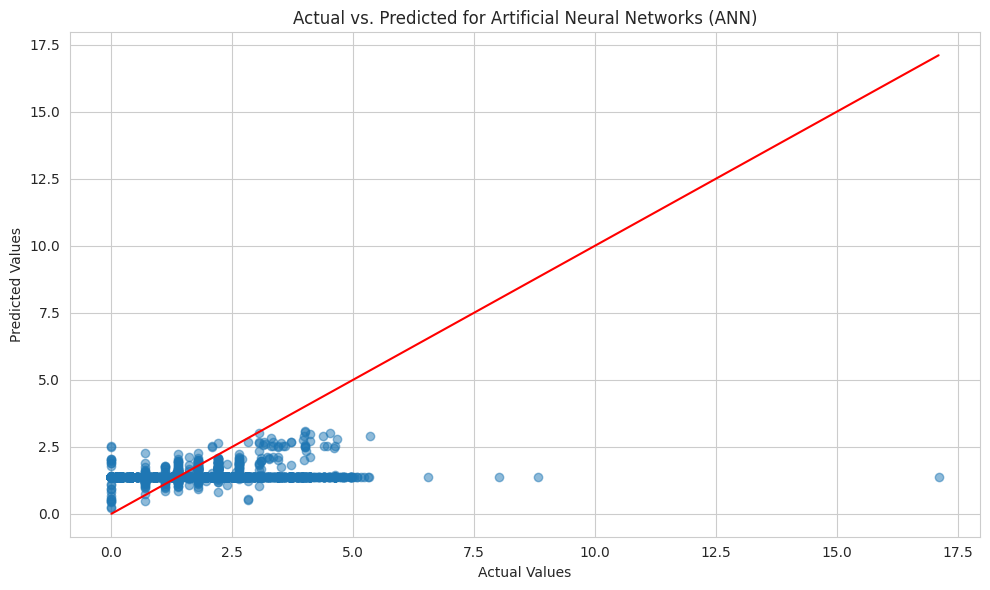

In [405]:
plot_actual_vs_predicted(y_test, ann_predictions, ann_model_name)

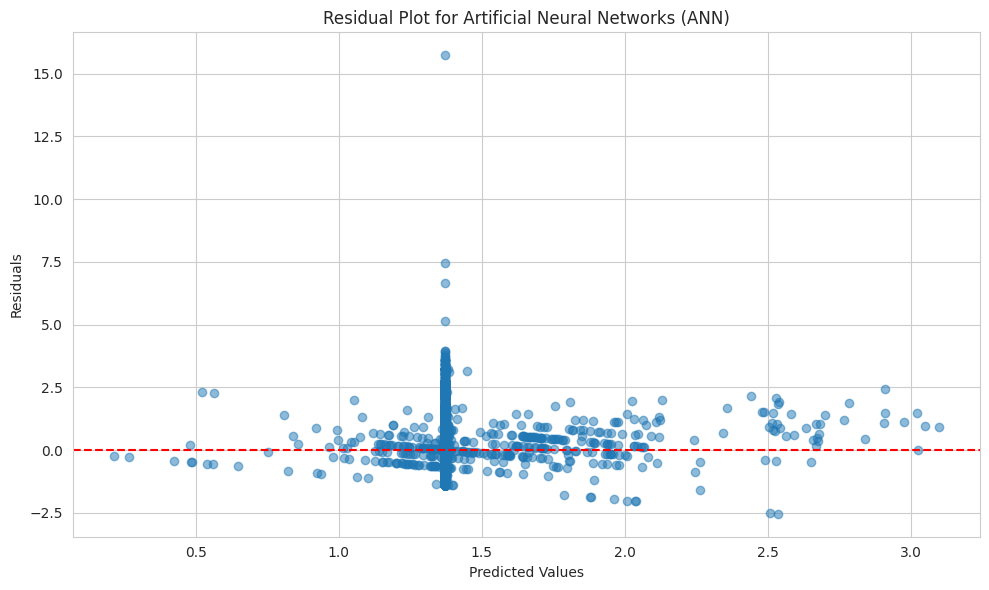

In [406]:
plot_residual(y_test, ann_predictions, ann_model_name)

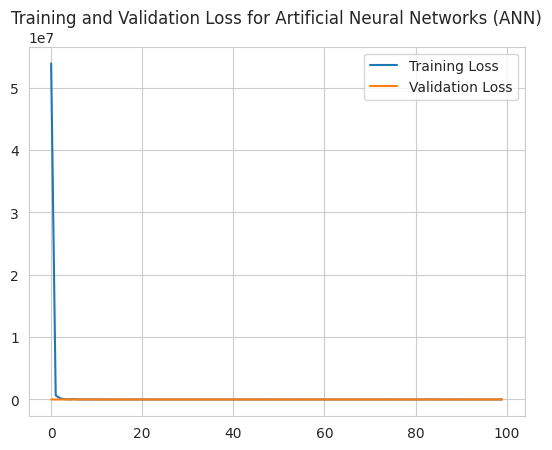

In [407]:
plot_neural_network_training_history(history, ann_model_name)

## Decision Trees

In [408]:
%%time
dtr_model_name = 'Decision Trees Regression'
dtr_model = DecisionTreeRegressor()
dtr_predictions = train_model(dtr_model, X_train, y_train, X_test)
print(f'{dtr_model_name} Metrics:')
dtr_model_metrics = evaluate_model(y_test, dtr_predictions)

Decision Trees Regression Metrics:
MSE: 0.6560761503853114
RMSE: 0.8099852778818337
MAE: 0.5589634826596974
R2: -0.012857919844557752
CPU times: user 829 ms, sys: 19.7 ms, total: 849 ms
Wall time: 848 ms


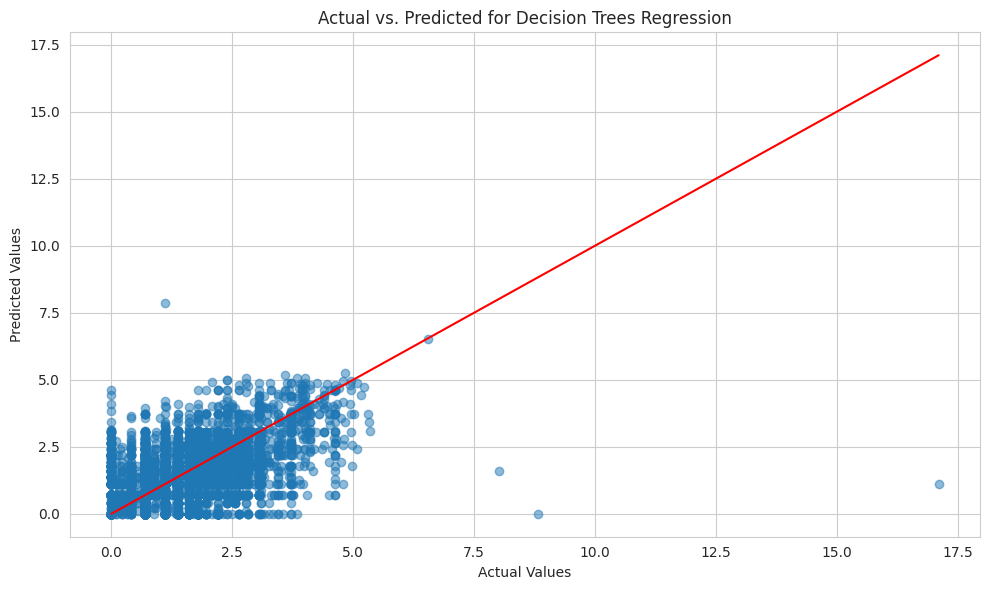

In [409]:
plot_actual_vs_predicted(y_test, dtr_predictions, dtr_model_name)

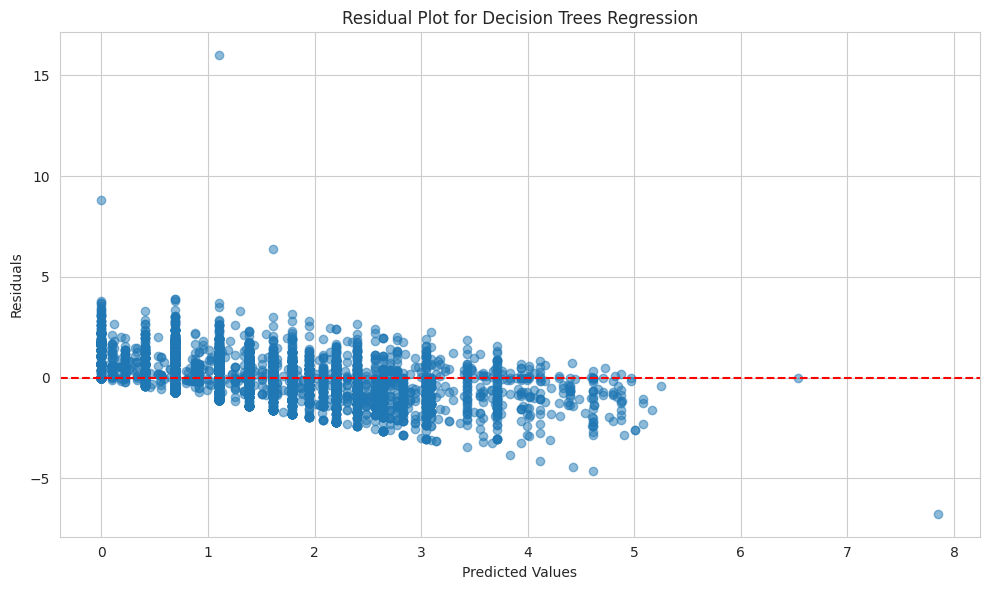

In [410]:
plot_residual(y_test, dtr_predictions, dtr_model_name)

# Model Development (With the selected features)

## Data Splitting

In [411]:
selected_features = ranked_features.index[:10]  # selecting top 10 features
X_selected = data[selected_features]

# Splitting the data with selected features
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [412]:
%%time
rf_model_selected_name = 'Random Forest Regression (with Selected Features)'
rf_model_selected = RandomForestRegressor(n_estimators=100, random_state=42)
rf_selected_predictions = train_model(rf_model_selected, X_train_selected, y_train_selected, X_test_selected)
print(f'{rf_model_selected_name} Metrics:')
rf_model_selected_metrics = evaluate_model(y_test_selected, rf_selected_predictions)

Random Forest Regression (with Selected Features) Metrics:
MSE: 0.545647859436871
RMSE: 0.7386798084670184
MAE: 0.5433599671825387
R2: 0.15762254800408892
CPU times: user 24.7 s, sys: 0 ns, total: 24.7 s
Wall time: 24.7 s


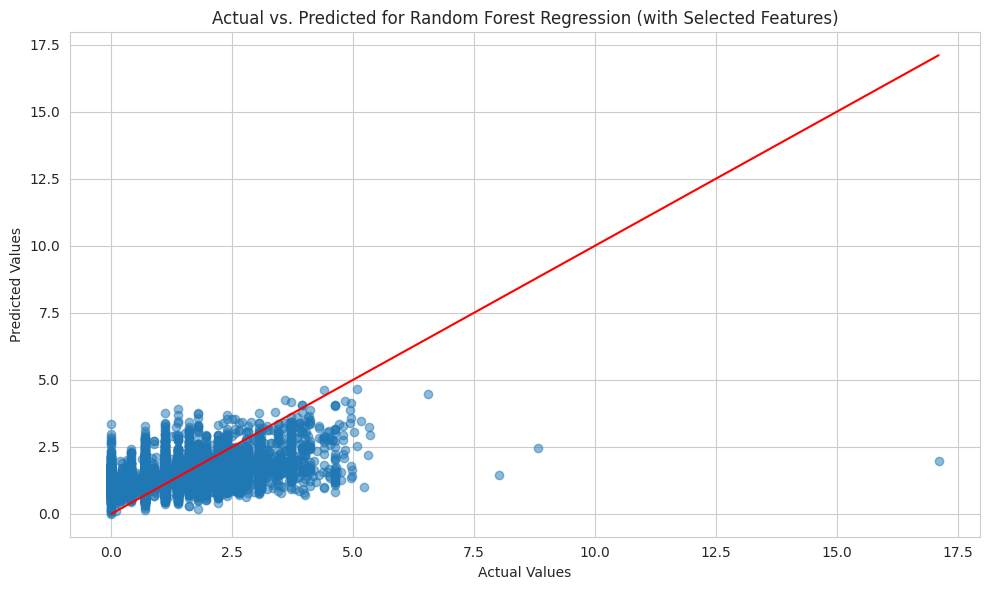

In [413]:
plot_actual_vs_predicted(y_test_selected, rf_selected_predictions, rf_model_selected_name)

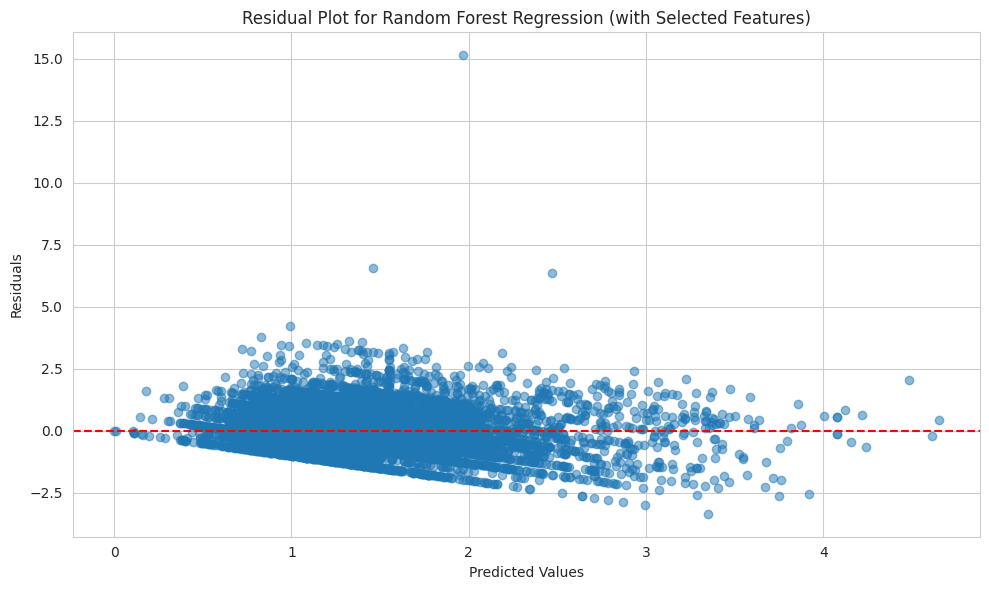

In [414]:
plot_residual(y_test_selected, rf_selected_predictions, rf_model_selected_name)

In [415]:
%%time
xgb_model_selected_name = 'Gradient Boosting Regression (with Selected Features)'
xgb_model_selected = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_selected_predictions = train_model(xgb_model_selected, X_train_selected, y_train_selected, X_test_selected)
print(f'{xgb_model_selected_name} Metrics:')
xgb_model_selected_metrics = evaluate_model(y_test_selected, xgb_selected_predictions)

Gradient Boosting Regression (with Selected Features) Metrics:
MSE: 0.5155632102144178
RMSE: 0.7180273046440628
MAE: 0.5337178191293487
R2: 0.204067576089337
CPU times: user 2min, sys: 0 ns, total: 2min
Wall time: 7.58 s


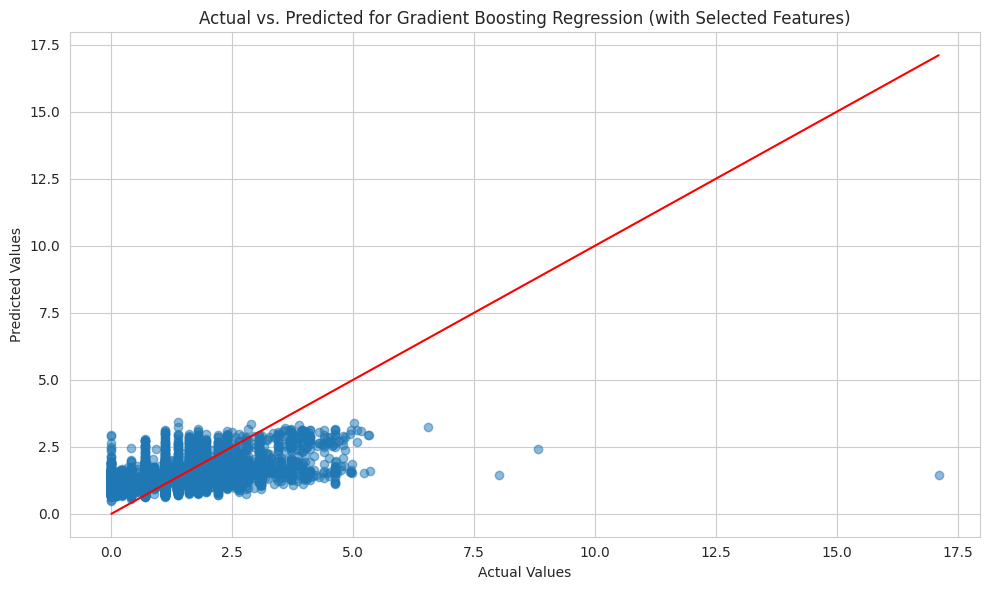

In [416]:
plot_actual_vs_predicted(y_test_selected, xgb_selected_predictions, xgb_model_selected_name)

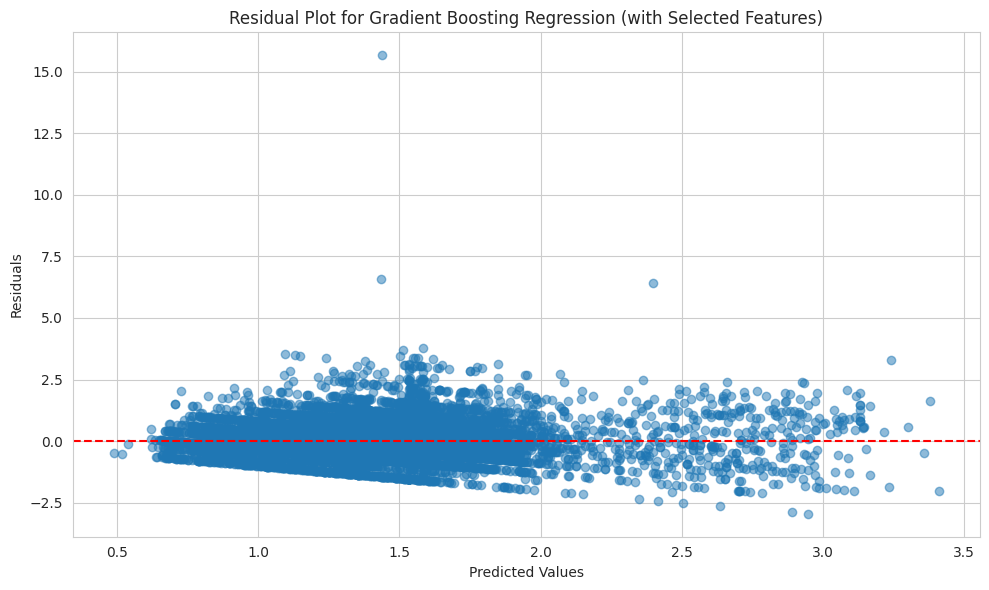

In [417]:
plot_residual(y_test_selected, xgb_selected_predictions, xgb_model_selected_name)

In [418]:
%%time
ann_model_selected_name = 'Artificial Neural Networks (with Selected Features)'
ann_predictions_selected, history_selected = train_ann_model(X_train_selected, y_train_selected, X_test_selected, y_test_selected)
print(f'{ann_model_selected_name} Metrics:')
ann_model_selected = evaluate_model(y_test_selected, ann_predictions_selected)

Epoch 1/100
1309/1309 [==============================] - 4s 2ms/step - loss: 87527576.0000 - val_loss: 160073.8594
Epoch 2/100
1309/1309 [==============================] - 3s 2ms/step - loss: 2554793.2500 - val_loss: 77000.4609
Epoch 3/100
1309/1309 [==============================] - 3s 2ms/step - loss: 544477.9375 - val_loss: 701.8534
Epoch 4/100
1309/1309 [==============================] - 3s 2ms/step - loss: 259427.9531 - val_loss: 388.9572
Epoch 5/100
1309/1309 [==============================] - 3s 2ms/step - loss: 134826.6094 - val_loss: 119.7786
Epoch 6/100
1309/1309 [==============================] - 2s 2ms/step - loss: 47665.1055 - val_loss: 67.3647
Epoch 7/100
1309/1309 [==============================] - 3s 2ms/step - loss: 74377.6016 - val_loss: 13.7235
Epoch 8/100
1309/1309 [==============================] - 3s 2ms/step - loss: 36653.1484 - val_loss: 2.0716
Epoch 9/100
1309/1309 [==============================] - 3s 2ms/step - loss: 15260.2021 - val_loss: 2.2029
Epoch 10/100

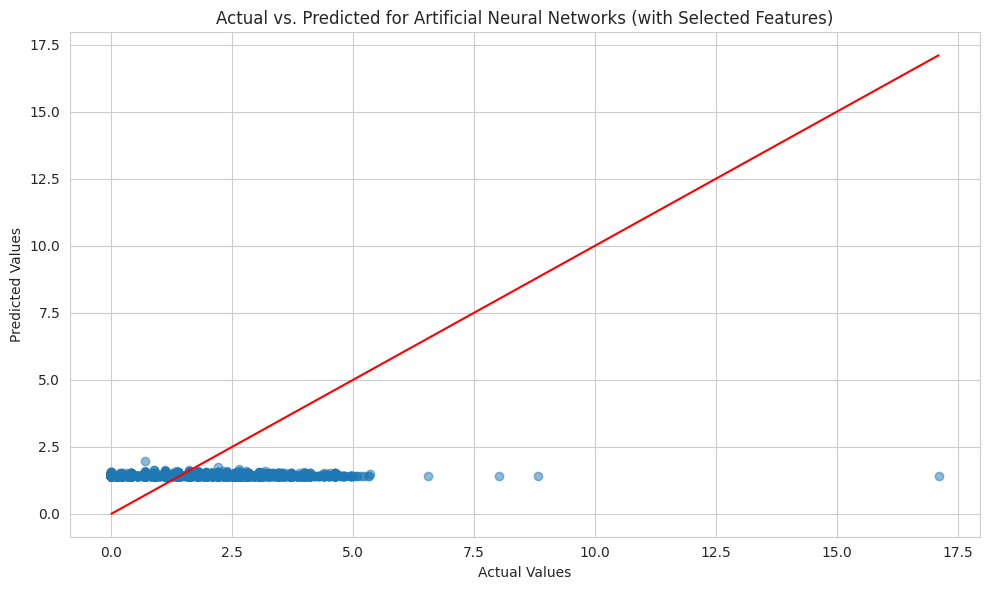

In [419]:
plot_actual_vs_predicted(y_test_selected, ann_predictions_selected, ann_model_selected_name)

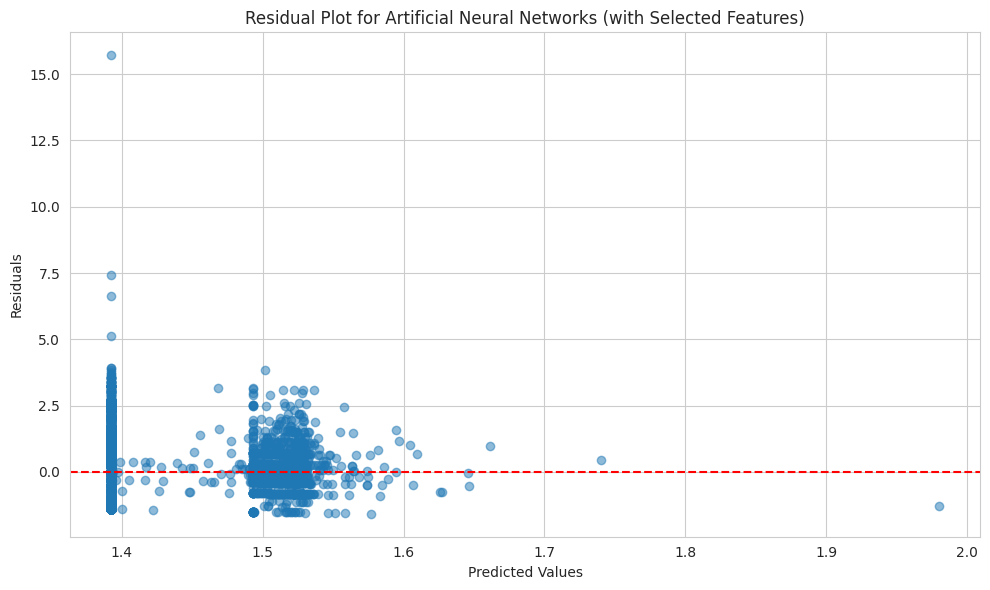

In [420]:
plot_residual(y_test_selected, ann_predictions_selected, ann_model_selected_name)

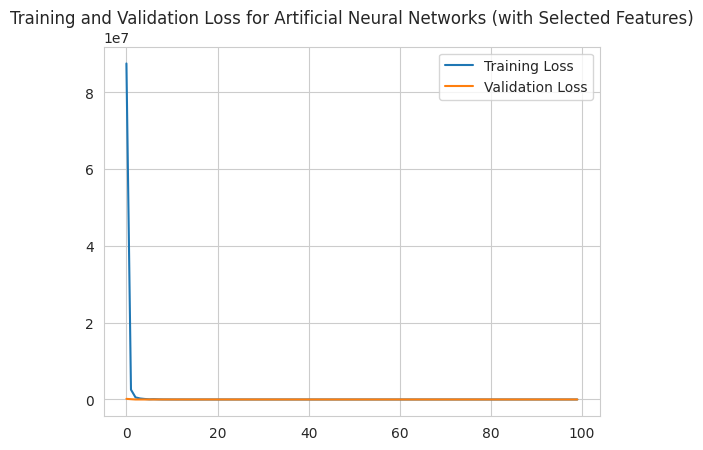

In [421]:
plot_neural_network_training_history(history_selected, ann_model_selected_name)

In [422]:
%%time
dtr_model_selected_name = 'Decision Trees Regression (with Selected Features)'
dtr_model_selected = DecisionTreeRegressor()
dtr_predictions_selected = train_model(dtr_model_selected, X_train_selected, y_train_selected, X_test_selected)
print(f'{dtr_model_selected_name} Metrics:')
dtr_model_metrics_selected = evaluate_model(y_test, dtr_predictions_selected)

Decision Trees Regression (with Selected Features) Metrics:
MSE: 0.9610824470151031
RMSE: 0.9803481254203035
MAE: 0.717177884347716
R2: -0.48373015466441904
CPU times: user 398 ms, sys: 0 ns, total: 398 ms
Wall time: 397 ms


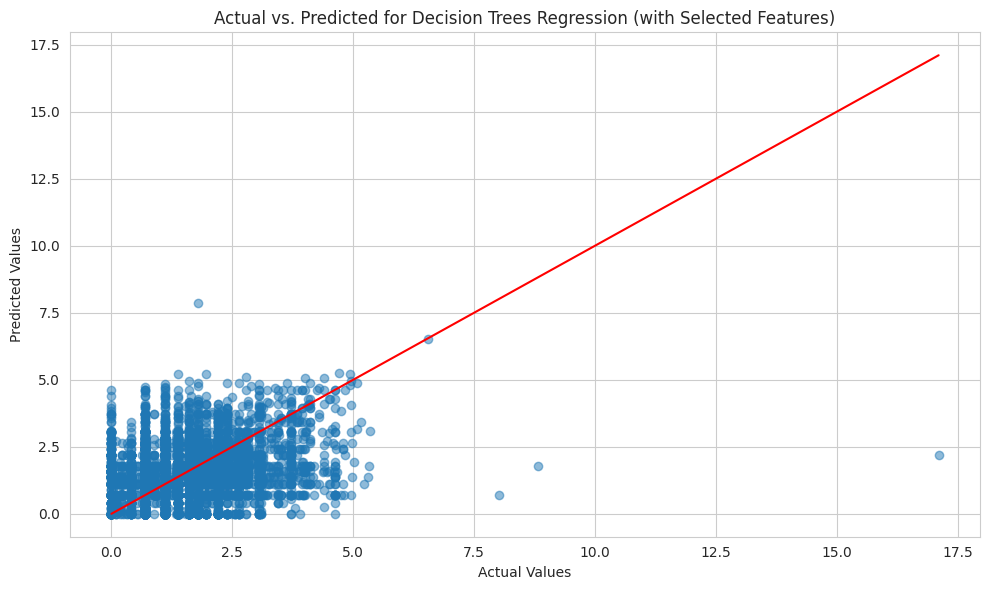

In [423]:
plot_actual_vs_predicted(y_test_selected, dtr_predictions_selected, dtr_model_selected_name)

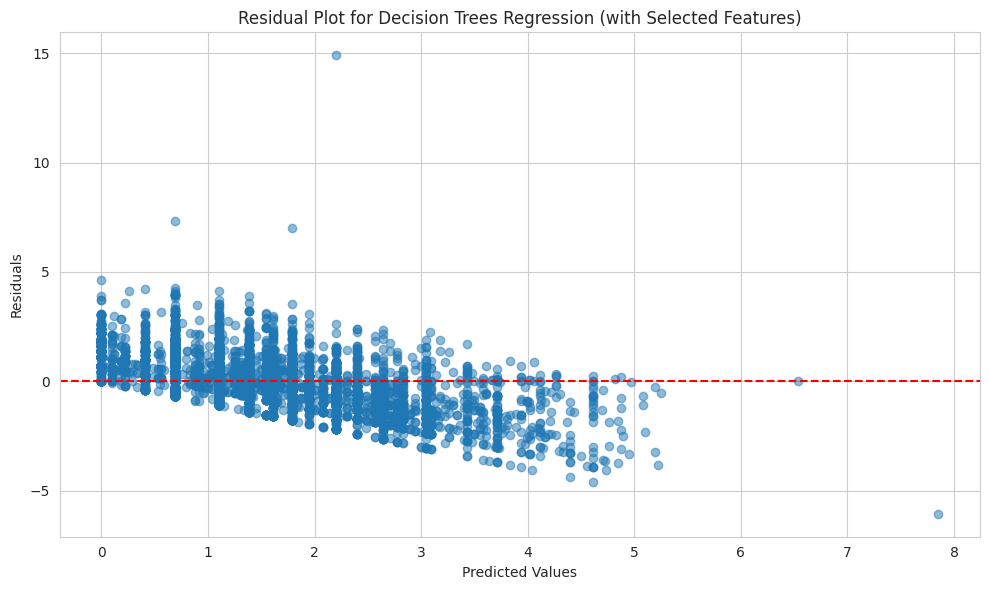

In [424]:
plot_residual(y_test_selected, dtr_predictions_selected, dtr_model_selected_name)

# Model Optimization

## Optimized the best model

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit to the data
grid_search.fit(X_train_selected, y_train_selected)
# grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print("Best parameters:")
print(best_params)

# Evaluate the model with the best parameters
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
optimized_rf_model_name = 'Optimized Random Forest Regression (with Selected Features)'

print(f'{optimized_rf_model_name} Metrics:')
optimized_rf_model_metrics_selected = evaluate_model(y_test_selected, y_pred_best_rf)
# optimized_rf_model_metrics = evaluate_model(y_test, dtr_predictions_selected)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  16.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  13.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  13.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=  39.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=  12.8s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  11.7s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=  36.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   7.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  22.3s
[CV] END max_dep

In [427]:
plot_actual_vs_predicted(y_test_selected, y_pred_best_rf, optimized_rf_model_name)

NameError: name 'y_pred_best_rf' is not defined

In [ ]:
plot_residual(y_test_selected, y_pred_best_rf, optimized_rf_model_name)

# Model Persistence

In [ ]:
from src.utils.model_persistence import save_model

In [ ]:
# Save model
save_model(model, '../artifacts/models/optimized_model.pkl')